In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection  import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# to make results reproducible
np.random.seed(1) #numpy random seed
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, AvgPool2D, Dropout
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [5]:
from keras import backend as K

In [6]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
x_test = pd.read_csv("../input/digit-recognizer/test.csv")

In [7]:
train.shape, x_test.shape

((42000, 785), (28000, 784))

There is 42000 images in training dataset and 28000 images in testing dataset, each image is 28x28 pixel.

In [8]:
x_train = train.drop(columns='label')
y = train.label

In [9]:
x_train = x_train/255
x_test = x_test/255

In [10]:
x_train.isnull().sum().sum(), x_test.isnull().sum().sum(), y.isnull().sum().sum()

(0, 0, 0)

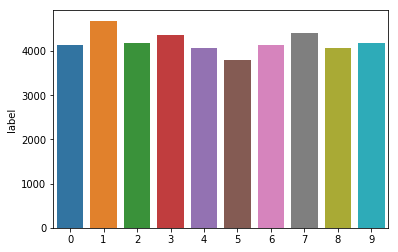

In [11]:
sns.barplot(y.value_counts().index, y.value_counts());

Distribution of classes across our dataset is quite uniform.

In [12]:
num_classes = len(y.value_counts())

In [13]:
y_train = to_categorical(y, num_classes)
y_train.shape

(42000, 10)

In [14]:
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size=0.1)

In [15]:
train_x.shape, train_y.shape, val_x.shape, val_y.shape

((37800, 784), (37800, 10), (4200, 784), (4200, 10))

### Neural Network Architecture - MLP


In [16]:
model = Sequential()
model.add(Dense(248, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(36,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 248)               194680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 248)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               31872     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 36)                4644      
_________________________________________________________________
dropout_3 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [18]:
history = model.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(val_x, val_y), verbose=0)
model.evaluate(val_x, val_y)

4200/4200 [==============================] - 0s 40us/step


[0.12480966948805006, 0.9783333539962769]

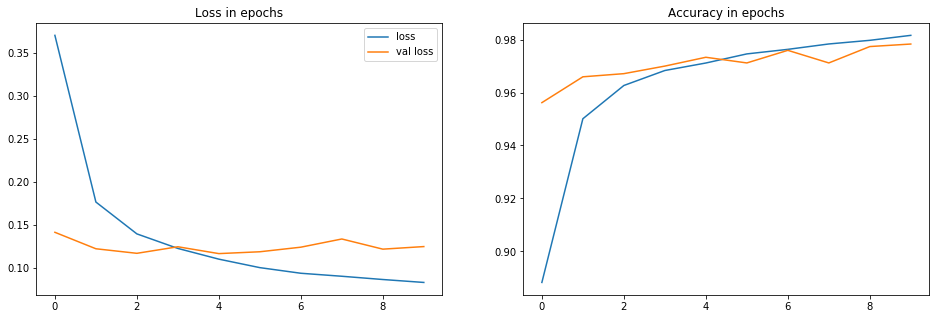

In [19]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.title("Loss in epochs")
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.subplot(1,2,2)
plt.title("Accuracy in epochs")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']);

Between epoch 3 and 5 there is a point where the neural network starts to overfit, the loss on training set continues to decrease whereas validation loss goes up.

Final accuracy score is 97.7% on validation set.

### Convolution NN

In [20]:
K.image_data_format()

'channels_last'

For CNN we have to contruct dataset in a little different manner.

In [21]:
x_train.shape

(42000, 784)

In [22]:
x_train = x_train.to_numpy().reshape(x_train.shape[0], 28, 28, 1)
x_train.shape

(42000, 28, 28, 1)

In [23]:
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train)

In [24]:
# Using LeNet-5 architecture
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(28, 28, 1), padding='same'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='tanh'))
model.add(Dense(84, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_6 (Dense)              (None, 84)               

In [25]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [26]:
history = model.fit(train_x, train_y, batch_size=32, epochs=10, validation_data=(val_x, val_y), verbose=0)
model.evaluate(val_x, val_y)

10500/10500 [==============================] - 1s 130us/step


[0.05975191720736967, 0.9845714569091797]

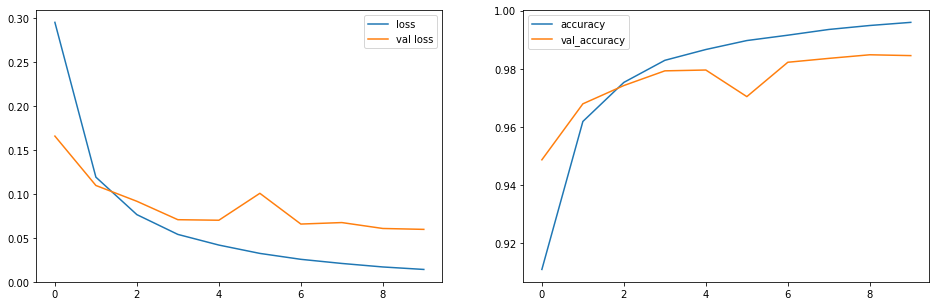

In [27]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy');
plt.legend();

Similarly as for MLP we can observe an overfitting effect.
Final accuracy is 98%

In [28]:
pred_y = model.predict(val_x)
pred_y.shape, val_y.shape

((10500, 10), (10500, 10))

In [29]:
y_pred = np.argmax(pred_y, axis=1)
y_val = np.argmax(val_y, axis=1)

In [30]:
print(confusion_matrix(y_val, y_pred))

[[1028    0    0    0    0    2    0    0    1    1]
 [   0 1175    3    2    0    0    0    3    0    0]
 [   3    2 1028    4    1    0    0   10    3    0]
 [   0    0    7 1022    0    7    0    4    5    3]
 [   2    2    1    0 1008    0    2    2    0    8]
 [   0    0    0    8    0  923    3    1    6    4]
 [   3    0    0    0    3    1  966    0    2    0]
 [   0    2    4    1    1    0    0 1094    3    5]
 [   0    3    1    4    1    2    1    1 1042    4]
 [   1    0    0    4    5    2    0    6    2 1052]]


In [31]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1032
           1       0.99      0.99      0.99      1183
           2       0.98      0.98      0.98      1051
           3       0.98      0.98      0.98      1048
           4       0.99      0.98      0.99      1025
           5       0.99      0.98      0.98       945
           6       0.99      0.99      0.99       975
           7       0.98      0.99      0.98      1110
           8       0.98      0.98      0.98      1059
           9       0.98      0.98      0.98      1072

    accuracy                           0.98     10500
   macro avg       0.98      0.98      0.98     10500
weighted avg       0.98      0.98      0.98     10500



The two most common mistakes the model is making is confusing 9 with 4 and 9 with 7, it is understandable as those figures looks similar, especially when sloppily hand written.

### Data augmentation

In [32]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [33]:
image_generator = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                     shear_range=0.1, zoom_range=0.1)
image_generator.fit(train_x)

In [34]:
image_it = image_generator.flow(train_x, train_y, batch_size=32)

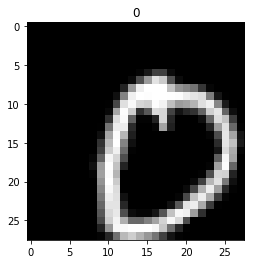

In [35]:
batch = image_it.next()
image = batch[0]
im_labels = batch[1]
image_nr = 22
plt.imshow(image[image_nr][:,:,0], cmap='gray');
plt.title(np.argmax(im_labels[image_nr]));

In [36]:
history = model.fit_generator(image_it, epochs = 20, validation_data = (val_x, val_y), verbose = 0)
model.evaluate(val_x, val_y)

10500/10500 [==============================] - 1s 129us/step


[0.03647532684157514, 0.9887619018554688]

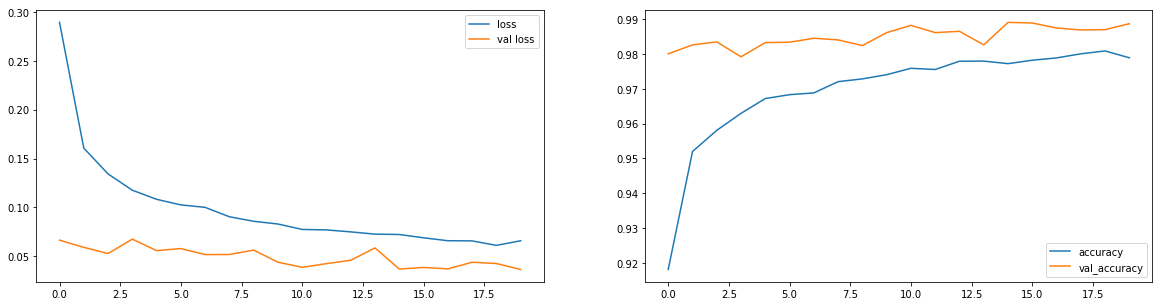

In [37]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend();
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy');
plt.legend();

### Learning rate decay
ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.

In [38]:
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001)

In [39]:
history = model.fit_generator(image_it, epochs = 20, validation_data = (val_x, val_y), verbose = 0, callbacks=[lr_decay])
model.evaluate(val_x, val_y)

10500/10500 [==============================] - 1s 130us/step


[0.029312108018382875, 0.9916190505027771]

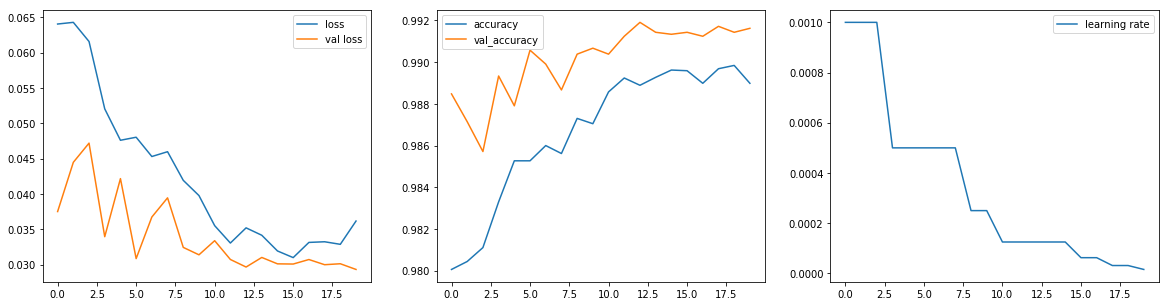

In [40]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend();
plt.subplot(1,3,2)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy');
plt.legend()
plt.subplot(1,3,3)
plt.plot(history.history['lr'], label = 'learning rate');
plt.legend();

In [41]:
test_x = x_test.to_numpy().reshape(x_test.shape[0], 28, 28, 1)

In [42]:
y_pred = model.predict(test_x)

In [43]:
submission = pd.DataFrame(zip(np.arange(1, len(y_pred)+1), np.argmax(y_pred, axis=1)), columns=['ImageId', 'Label'])

In [44]:
submission.to_csv('recognized_digits.csv',index=False)